In [1]:

import numpy as np
import os
import matplotlib.pyplot as plt
import math # For radians in rose plot
from matplotlib.colors import ListedColormap

from IPython.display import display
from plotly.subplots import make_subplots
import plotly.graph_objects as go


import random
import subprocess
import json # Import json to load the stats file
import pandas as pd # Import pandas for DataFrame summary
from utilities import plot_fault_counts, plot_histogram, plot_rose_diagram, append_param_to_cmd, normalize, plot_fault_points, count_pixels   
from IPython.display import display
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import shutil

from tqdm import trange

---

---

# Data Generation

In [2]:
# ─── 0) User picks parameters ────────────────────────────────────────────
mask_mode    = 0 # 0 binary (0, 1) | 1 Multiclass (0, 1, 2), normal and inverse faults

num_pairs    = 100
train_split = 80 # for training
val_split = 20 # for validation

cube_size    = 128
ricker_freq = (5, 35)      # Hz or (min, max)
seismic_noise = (0.1, 0.5)      # None | float | (min, max)
ricker_dt    = 0.002
wavelet_len  = 0.2        # s
num_gauss    = (2,10)     # int or (min, max)
num_faults = (0,4)       # int or (min, max) faults per cube
max_disp   = (-50, 50)   # int or (min, max) max displacement magnitude per cube
strike     = (0,360)      # deg or (min, max) strike angle per fault
dip        = (35,70) # deg or (min, max) dip angle per fault
output_format = "npy" # npy, npz, or dat

In [3]:
# explicit counts
num_train = int(train_split)
num_val   = int(val_split)

if num_train + num_val != num_pairs:
    raise ValueError(
        f"ERROR: train+val ({num_train + num_val}) "
        f"does not equal num_pairs ({num_pairs})."
    )
else:
    print(f"✔  Using {num_train} training and {num_val} validation cubes.")

✔  Using 80 training and 20 validation cubes.


In [4]:
# ───────────────────────────────────────────────────────────────
# 1)  ROOT directory – works in .py or notebook
# ───────────────────────────────────────────────────────────────
try:                                   # for plain-.py execution
    ROOT_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:                      # Jupyter / IPython
    ROOT_DIR = os.getcwd()

In [5]:
# ───────────────────────────────────────────────────────────────
# 2)  Centralised output locations  (⇦ NEW)
# ───────────────────────────────────────────────────────────────
DATA_DIR   = os.path.join(ROOT_DIR, "data")        # …/generateSynthData/data
STATS_DIR  = os.path.join(ROOT_DIR, "statistics")  # …/generateSynthData/statistics
IMAGE_DIR  = os.path.join(ROOT_DIR, "images")      # …/generateSynthData/images

# make sure they exist
for _d in (DATA_DIR, STATS_DIR, IMAGE_DIR):
    os.makedirs(_d, exist_ok=True)

In [6]:

# ─── 1) Call your script (passing parameters from notebook variables) ─────────────────
script = os.path.join(ROOT_DIR, "synthDataGeneration.py")
base_out = DATA_DIR # os.path.expanduser("/home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/new_data")

# --------------------------------------------------------------
# create / clean output folders *before* the external script runs
# --------------------------------------------------------------
for split in ("train", "validation"):
    split_dir = os.path.join(base_out, split)
    if os.path.isdir(split_dir):
        shutil.rmtree(split_dir)       # wipe any previous run completely
        print(f"Removed old split folder: {split_dir}")
        
# Create output directory if it doesn't exist
os.makedirs(base_out, exist_ok=True)

print(f"Running script: {script}")
print(f"Output directory: {base_out}")

# Calculate the number of samples for each set
num_train = int(np.floor(num_pairs * train_split))
num_val = num_pairs - num_train

# Construct the command
cmd = [
    "python", script,
    "--num-pairs",     str(num_pairs),
    "--size",          str(cube_size),
    "--dt",            str(ricker_dt),
    "--length",        str(wavelet_len),
    "--mask-mode",     str(mask_mode),
    "--format",        output_format,
    "--output-dir",    base_out,
    "--train-split",   str(train_split),
    "--val-split",     str(val_split),
    "--faults",        f"{num_faults[0]},{num_faults[1]}",
    f"--max-disp={max_disp[0]},{max_disp[1]}",      # ← changed
    "--strike",        f"{strike[0]},{strike[1]}",
    "--dip",           f"{dip[0]},{dip[1]}",
    "--freq",          f"{ricker_freq[0]},{ricker_freq[1]}",
    "--num-gaussians", f"{num_gauss[0]},{num_gauss[1]}",
    "--noise",         f"{seismic_noise[0]},{seismic_noise[1]}",
]


# Run the command
result = subprocess.run(cmd, text=True) #result = subprocess.run(cmd, capture_output=True, text=True)

if result.returncode == 0:
    print("Data generation successful!")
    print(result.stdout)
else:
    print("Data generation failed.")
    print(result.stderr)

for fname in ("statistics_full.json",
              "statistics_train.json",
              "statistics_validation.json"):
    src = os.path.join(base_out, fname)
    dst = os.path.join(STATS_DIR, fname)
    if os.path.exists(src):
        try:
            os.replace(src, dst)          # move (overwrite if exists)
            print(f"Moved {fname} → {STATS_DIR}")
        except Exception as e:
            print(f"Could not move {fname}: {e}")
    else:
        print(f"Warning: {fname} not found in {base_out}")
        
# Data generation statistics
stats = {
    "total_pairs": num_pairs,
    "train_pairs": num_train,
    "validation_pairs": num_val,
}

# Save statistics to a JSON file
stats_file_path = os.path.join(STATS_DIR, "stats_data.json")
with open(stats_file_path, 'w') as f:
    json.dump(stats, f, indent=4)

print(f"Data generation complete. Statistics saved to {stats_file_path}")

Removed old split folder: /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data/train
Removed old split folder: /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data/validation
Running script: /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/synthDataGeneration.py
Output directory: /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data

Data split: 80 train, 20 validation.
Output format: npy

Starting data generation for 100 pairs...


Generating Cubes:  99%|█████████▉| 99/100 [01:30<00:00,  1.13it/s]


--- Saving Statistics Files ---
Saved full statistics to /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data/statistics_full.json
Saved train statistics to /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data/statistics_train.json
Saved validation statistics to /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data/statistics_validation.json

[2025-08-05 23:21:13] Generation complete.
 • train/seis/ → /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data/train/seis
 • train/fault/ → /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data/train/fault
 • validation/seis/ → /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data/validation/seis
 • validation/fault/ → /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data/validation/fault
Done ✅
Data generation successful!
None
Moved statistics_full.json → /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/statistics
Moved statistics_train.json → /home/roderickpere

Generating Cubes: 100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


In [7]:
# ─── 2) Check the output ────────────────────────────────────────────────
# Check the total number of files created across all splits
total_files_generated = 0
for split in ['train', 'validation']:
    seis_dir = os.path.join(base_out, split, 'seis')
    if os.path.exists(seis_dir):
        total_files_generated += len(os.listdir(seis_dir))

if total_files_generated != num_pairs:
    print(f"\nWarning: Mismatch in generated files ({total_files_generated}) and requested pairs ({num_pairs}). Check script output.")
else:
    print(f"\nSuccessfully generated {total_files_generated} file pairs.")


Successfully generated 100 file pairs.


In [8]:
# Append parameters that can be fixed values or ranges
def append_param_to_cmd(cmd_list, arg_name, value):
    if value is not None:
        if isinstance(value, tuple):
            cmd_list += [f"--{arg_name}", f"{value[0]},{value[1]}"]
        else:
            cmd_list += [f"--{arg_name}", str(value)]

In [9]:
print("\nCommand to run:")
print(" ".join(cmd)) # type: ignore # Print the corrected command
print("\nRunning subprocess...")

# run and capture output
# check=False allows inspection of returncode without raising exception immediately
result = subprocess.run(cmd, capture_output=True, text=True, check=False)
print("=== STDOUT ===\n", result.stdout)
print("=== STDERR ===\n", result.stderr)

if result.returncode != 0:
    print(f"Error: Script exited with return code {result.returncode}")
    # Optionally print more context or raise error
    # raise subprocess.CalledProcessError(result.returncode, cmd, output=result.stdout, stderr=result.stderr)
    # Exit this cell or notebook execution if script failed critically?
    # For now, just print error and continue, assuming stats file might still be partially saved
else:
    print("Script finished successfully.")

# Check if the expected number of files were generated
total_files_generated = 0
for split in ['train', 'validation']:
    seis_dir = os.path.join(base_out, split, 'seis')
    if os.path.exists(seis_dir):
        total_files_generated += len([f for f in os.listdir(seis_dir) if f.endswith((".npy", ".npz", ".dat"))])

if total_files_generated != num_pairs:
    print(f"\nWarning: Mismatch in generated files ({total_files_generated}) and requested pairs ({num_pairs}). Check script output.")
else:
    print(f"\nSuccessfully generated {total_files_generated} file pairs across all splits.")


Command to run:
python /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/synthDataGeneration.py --num-pairs 100 --size 128 --dt 0.002 --length 0.2 --mask-mode 0 --format npy --output-dir /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data --train-split 80 --val-split 20 --faults 0,4 --max-disp=-50,50 --strike 0,360 --dip 35,70 --freq 5,35 --num-gaussians 2,10 --noise 0.1,0.5

Running subprocess...
=== STDOUT ===
 Cleaned directory: /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data/train
Cleaned directory: /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data/validation

Data split: 80 train, 20 validation.
Output format: npy

Starting data generation for 100 pairs...

--- Saving Statistics Files ---
Saved full statistics to /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data/statistics_full.json
Saved train statistics to /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data/statistics_train.json
Saved validation statis

In [10]:
# ─── 2) Load generated data and statistics ───────────────────────────────────────────────────────

# Define the base output directory
#base_out = os.path.expanduser("/Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output")

# Define the splits and their expected number of files
splits = {
    "train": num_train,
    "validation": num_val
}

# Check if the expected number of files were generated for each split
for split, expected_files in splits.items():
    seis_dir = os.path.join(base_out, split, "seis")
    fault_dir = os.path.join(base_out, split, "fault")

    if os.path.exists(seis_dir):
        files = sorted(f for f in os.listdir(seis_dir) if f.endswith((".npy", ".npz", ".dat")))
        n_files = len(files)
        if n_files != expected_files:
            print(f"Warning: Mismatch in generated files for '{split}' split. Expected {expected_files}, found {n_files} in {seis_dir}")
    else:
        print(f"Warning: Seismic output directory not found for '{split}' split: {seis_dir}")

    if not os.path.exists(fault_dir):
        print(f"Warning: Fault output directory not found for '{split}' split: {fault_dir}")

# Load the statistics files
stats_data = {}
for split in splits.keys():
    stats_file_path = os.path.join(STATS_DIR, f"statistics_{split}.json")
    if os.path.exists(stats_file_path):
        with open(stats_file_path, 'r') as f:
            stats_data[split] = json.load(f)
            print(f"Successfully loaded statistics for '{split}' split.")
    else:
        print(f"Warning: Statistics file not found for '{split}' split: {stats_file_path}")

# Load the full statistics file
full_stats_path = os.path.join(STATS_DIR, "statistics_full.json")
if os.path.exists(full_stats_path):
    with open(full_stats_path, 'r') as f:
        full_stats = json.load(f)
        print("Successfully loaded full statistics.")
else:
    print(f"Warning: Full statistics file not found: {full_stats_path}")

Successfully loaded statistics for 'train' split.
Successfully loaded statistics for 'validation' split.
Successfully loaded full statistics.


In [11]:
# Load all statistics: full, prediction, train, and validation
stats_files = {
    "full": os.path.join(STATS_DIR, "statistics_full.json"),
    "train": os.path.join(STATS_DIR, "statistics_train.json"),
    "validation": os.path.join(STATS_DIR, "statistics_validation.json")
}

all_stats_data = {}
for split, path in stats_files.items():
    if os.path.exists(path):
        try:
            with open(path, 'r') as f:
                all_stats_data[split] = json.load(f)
            print(f"Loaded statistics for '{split}' from {path}")
        except Exception as e:
            print(f"Error loading statistics for '{split}': {e}")
            all_stats_data[split] = None
    else:
        print(f"Statistics file not found for '{split}': {path}")
        all_stats_data[split] = None

Loaded statistics for 'full' from /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/statistics/statistics_full.json
Loaded statistics for 'train' from /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/statistics/statistics_train.json
Loaded statistics for 'validation' from /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/statistics/statistics_validation.json



--- Displaying Statistics and Plots for full data ---

Cube Generation Parameter Summary:
             freq  noise_sigma  num_gaussians  num_faults_generated
count  100.000000   100.000000     100.000000            100.000000
mean    19.602653     0.301518       6.170000              2.160000
std      9.195652     0.107339       2.490609              1.390589
min      5.208238     0.109916       2.000000              0.000000
25%     11.107273     0.221219       4.000000              1.000000
50%     19.819122     0.301931       6.000000              2.000000
75%     27.468702     0.377215       8.250000              3.000000
max     34.710405     0.495359      10.000000              4.000000

Pixel-class distribution – OVERALL (% of all voxels):
    no_fault:  98.50 %
       fault:   1.50 %
Pixel-class distribution – MEAN PER CUBE:
    no_fault:  98.50 %
       fault:   1.50 %
Saved figure → /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/images/full_dataset_stats.png


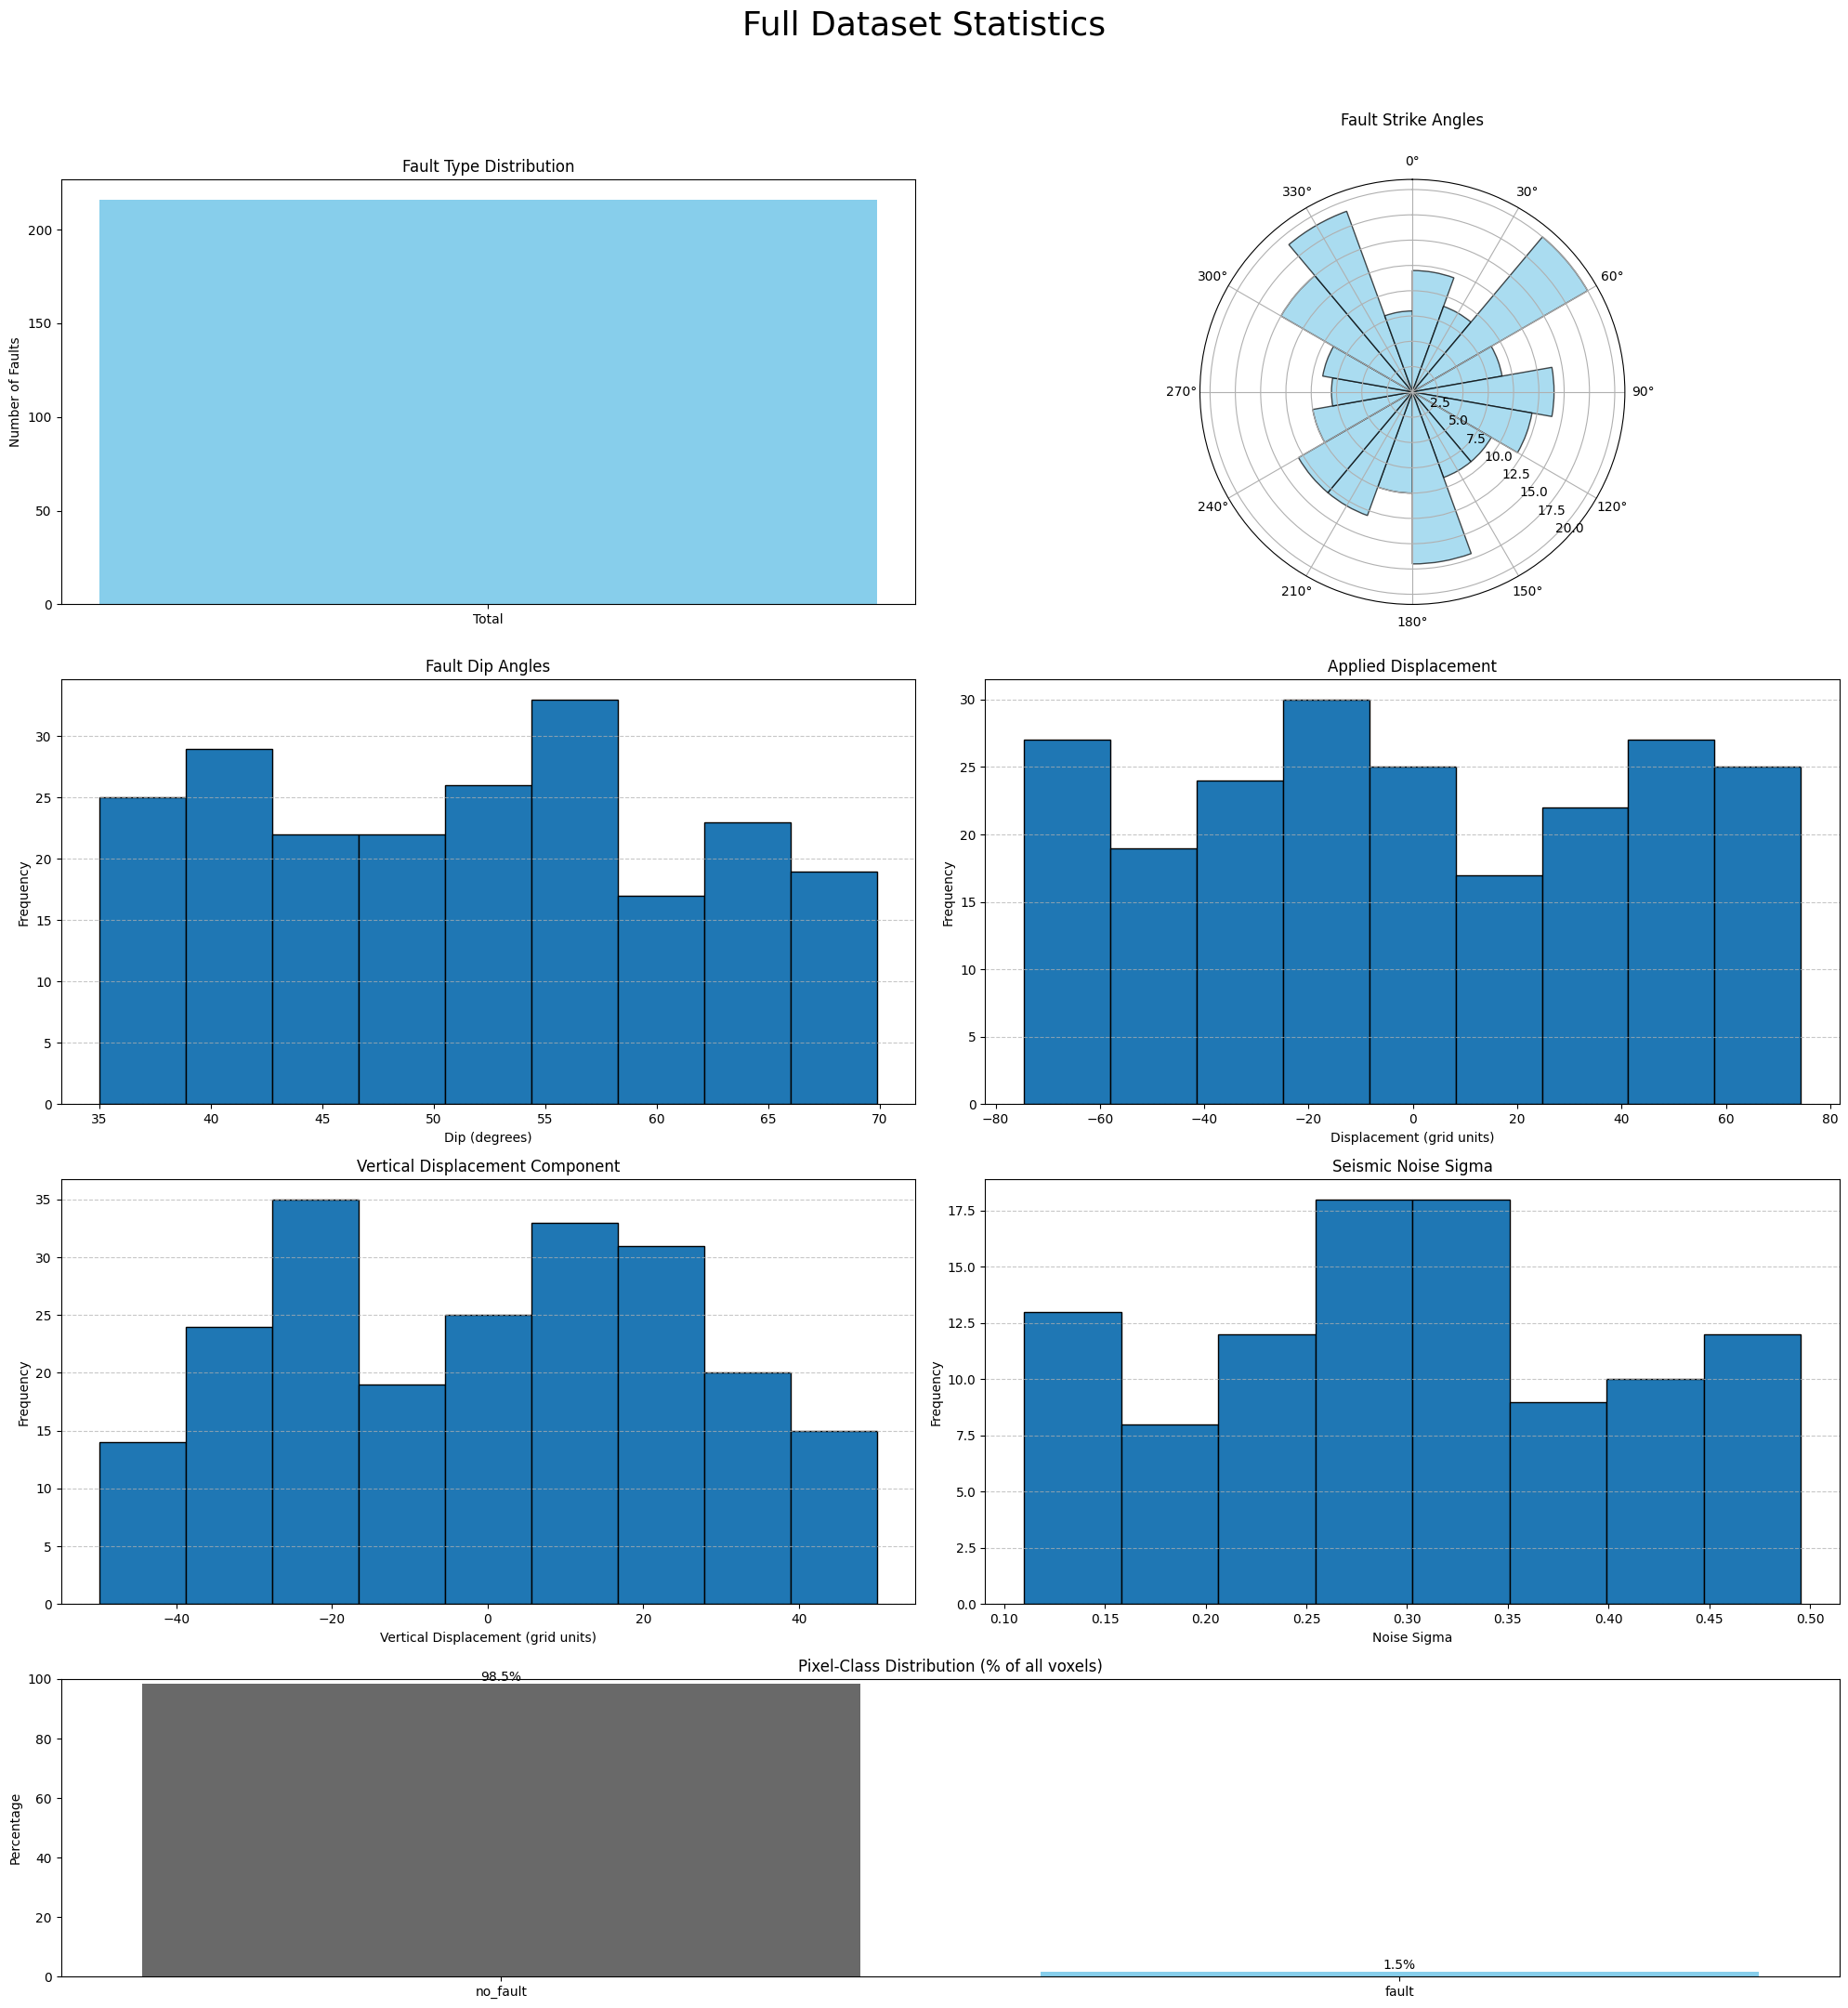


--- Displaying Statistics and Plots for train data ---

Cube Generation Parameter Summary:
            freq  noise_sigma  num_gaussians  num_faults_generated
count  80.000000    80.000000      80.000000             80.000000
mean   19.960281     0.306639       6.175000              2.125000
std     9.289837     0.109438       2.534696              1.372192
min     5.208238     0.109916       2.000000              0.000000
25%    11.178323     0.223723       4.000000              1.000000
50%    19.819122     0.310369       6.000000              2.000000
75%    28.106888     0.391499       8.250000              3.000000
max    34.710405     0.495359      10.000000              4.000000

Pixel-class distribution – OVERALL (% of all voxels):
    no_fault:  98.53 %
       fault:   1.47 %
Pixel-class distribution – MEAN PER CUBE:
    no_fault:  98.53 %
       fault:   1.47 %
Saved figure → /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/images/train_dataset_stats.png


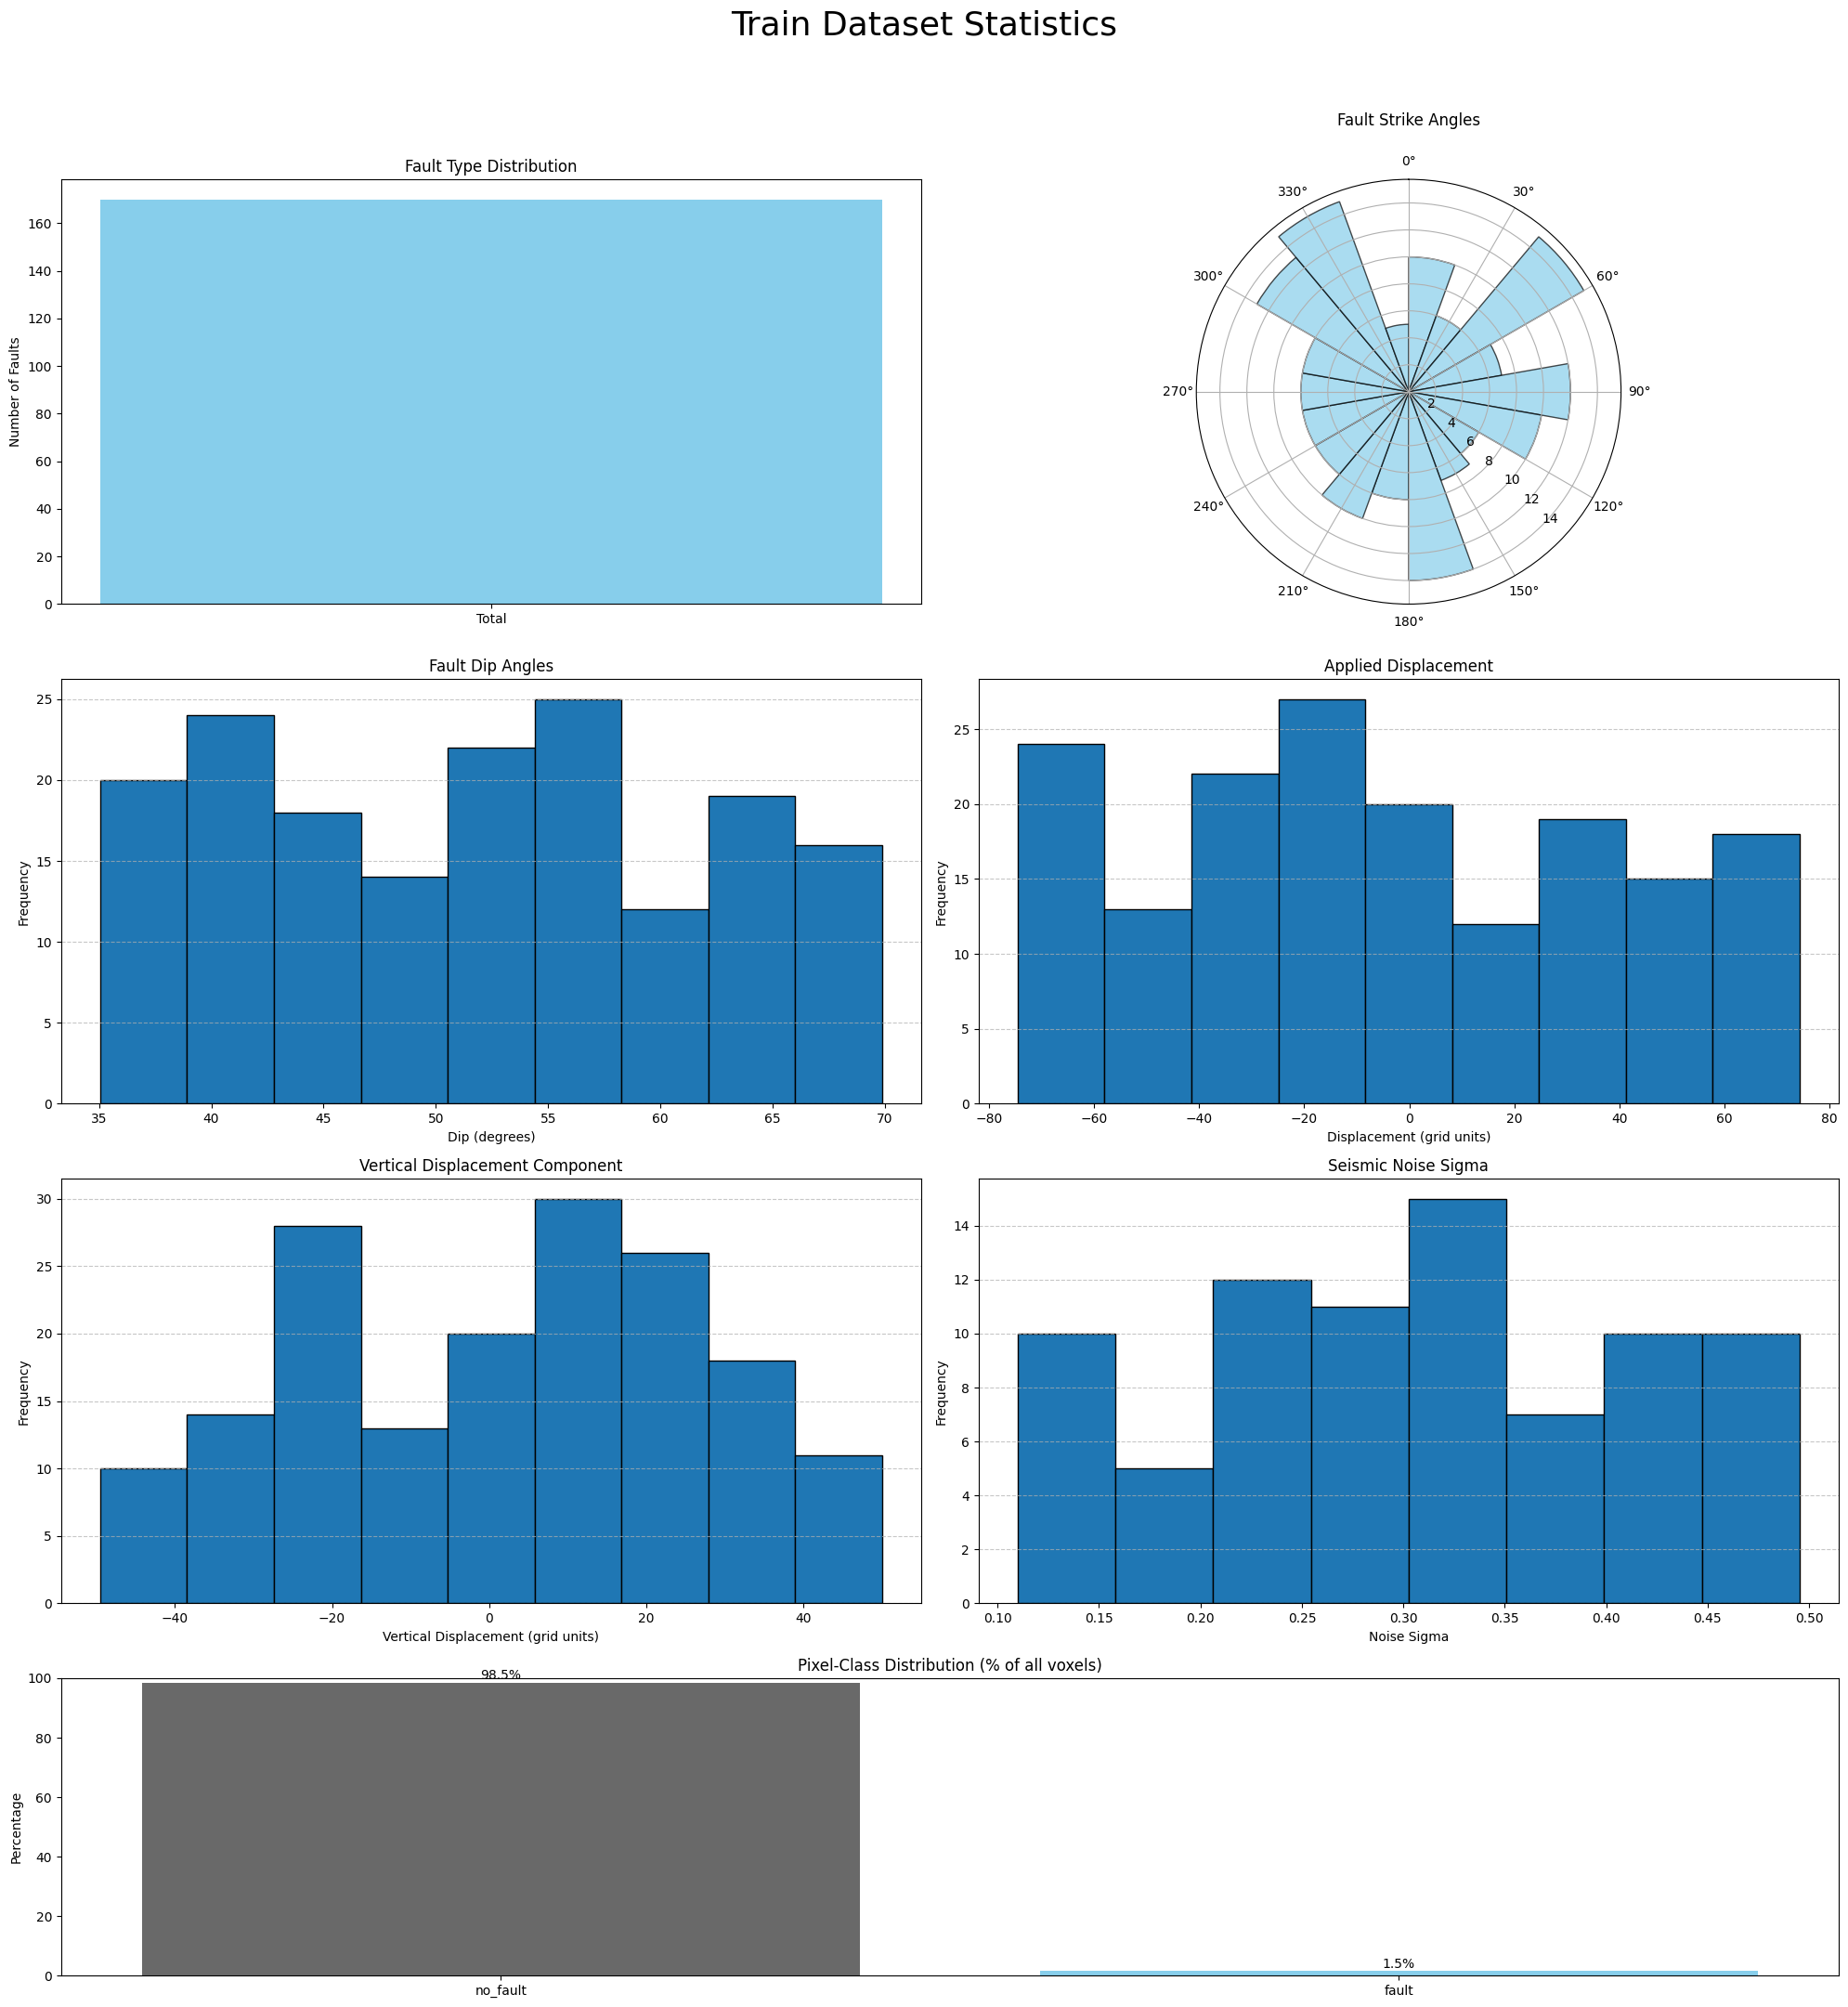


--- Displaying Statistics and Plots for validation data ---

Cube Generation Parameter Summary:
            freq  noise_sigma  num_gaussians  num_faults_generated
count  20.000000    20.000000      20.000000              20.00000
mean   18.172140     0.281034       6.150000               2.30000
std     8.892628     0.098408       2.368099               1.49032
min     5.766149     0.117476       2.000000               0.00000
25%    10.150182     0.204822       4.750000               1.00000
50%    19.312132     0.290063       6.000000               2.00000
75%    25.793557     0.328225       8.250000               4.00000
max    32.665820     0.482428      10.000000               4.00000

Pixel-class distribution – OVERALL (% of all voxels):
    no_fault:  98.36 %
       fault:   1.64 %
Pixel-class distribution – MEAN PER CUBE:
    no_fault:  98.36 %
       fault:   1.64 %
Saved figure → /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/images/validation_dataset_stats.png


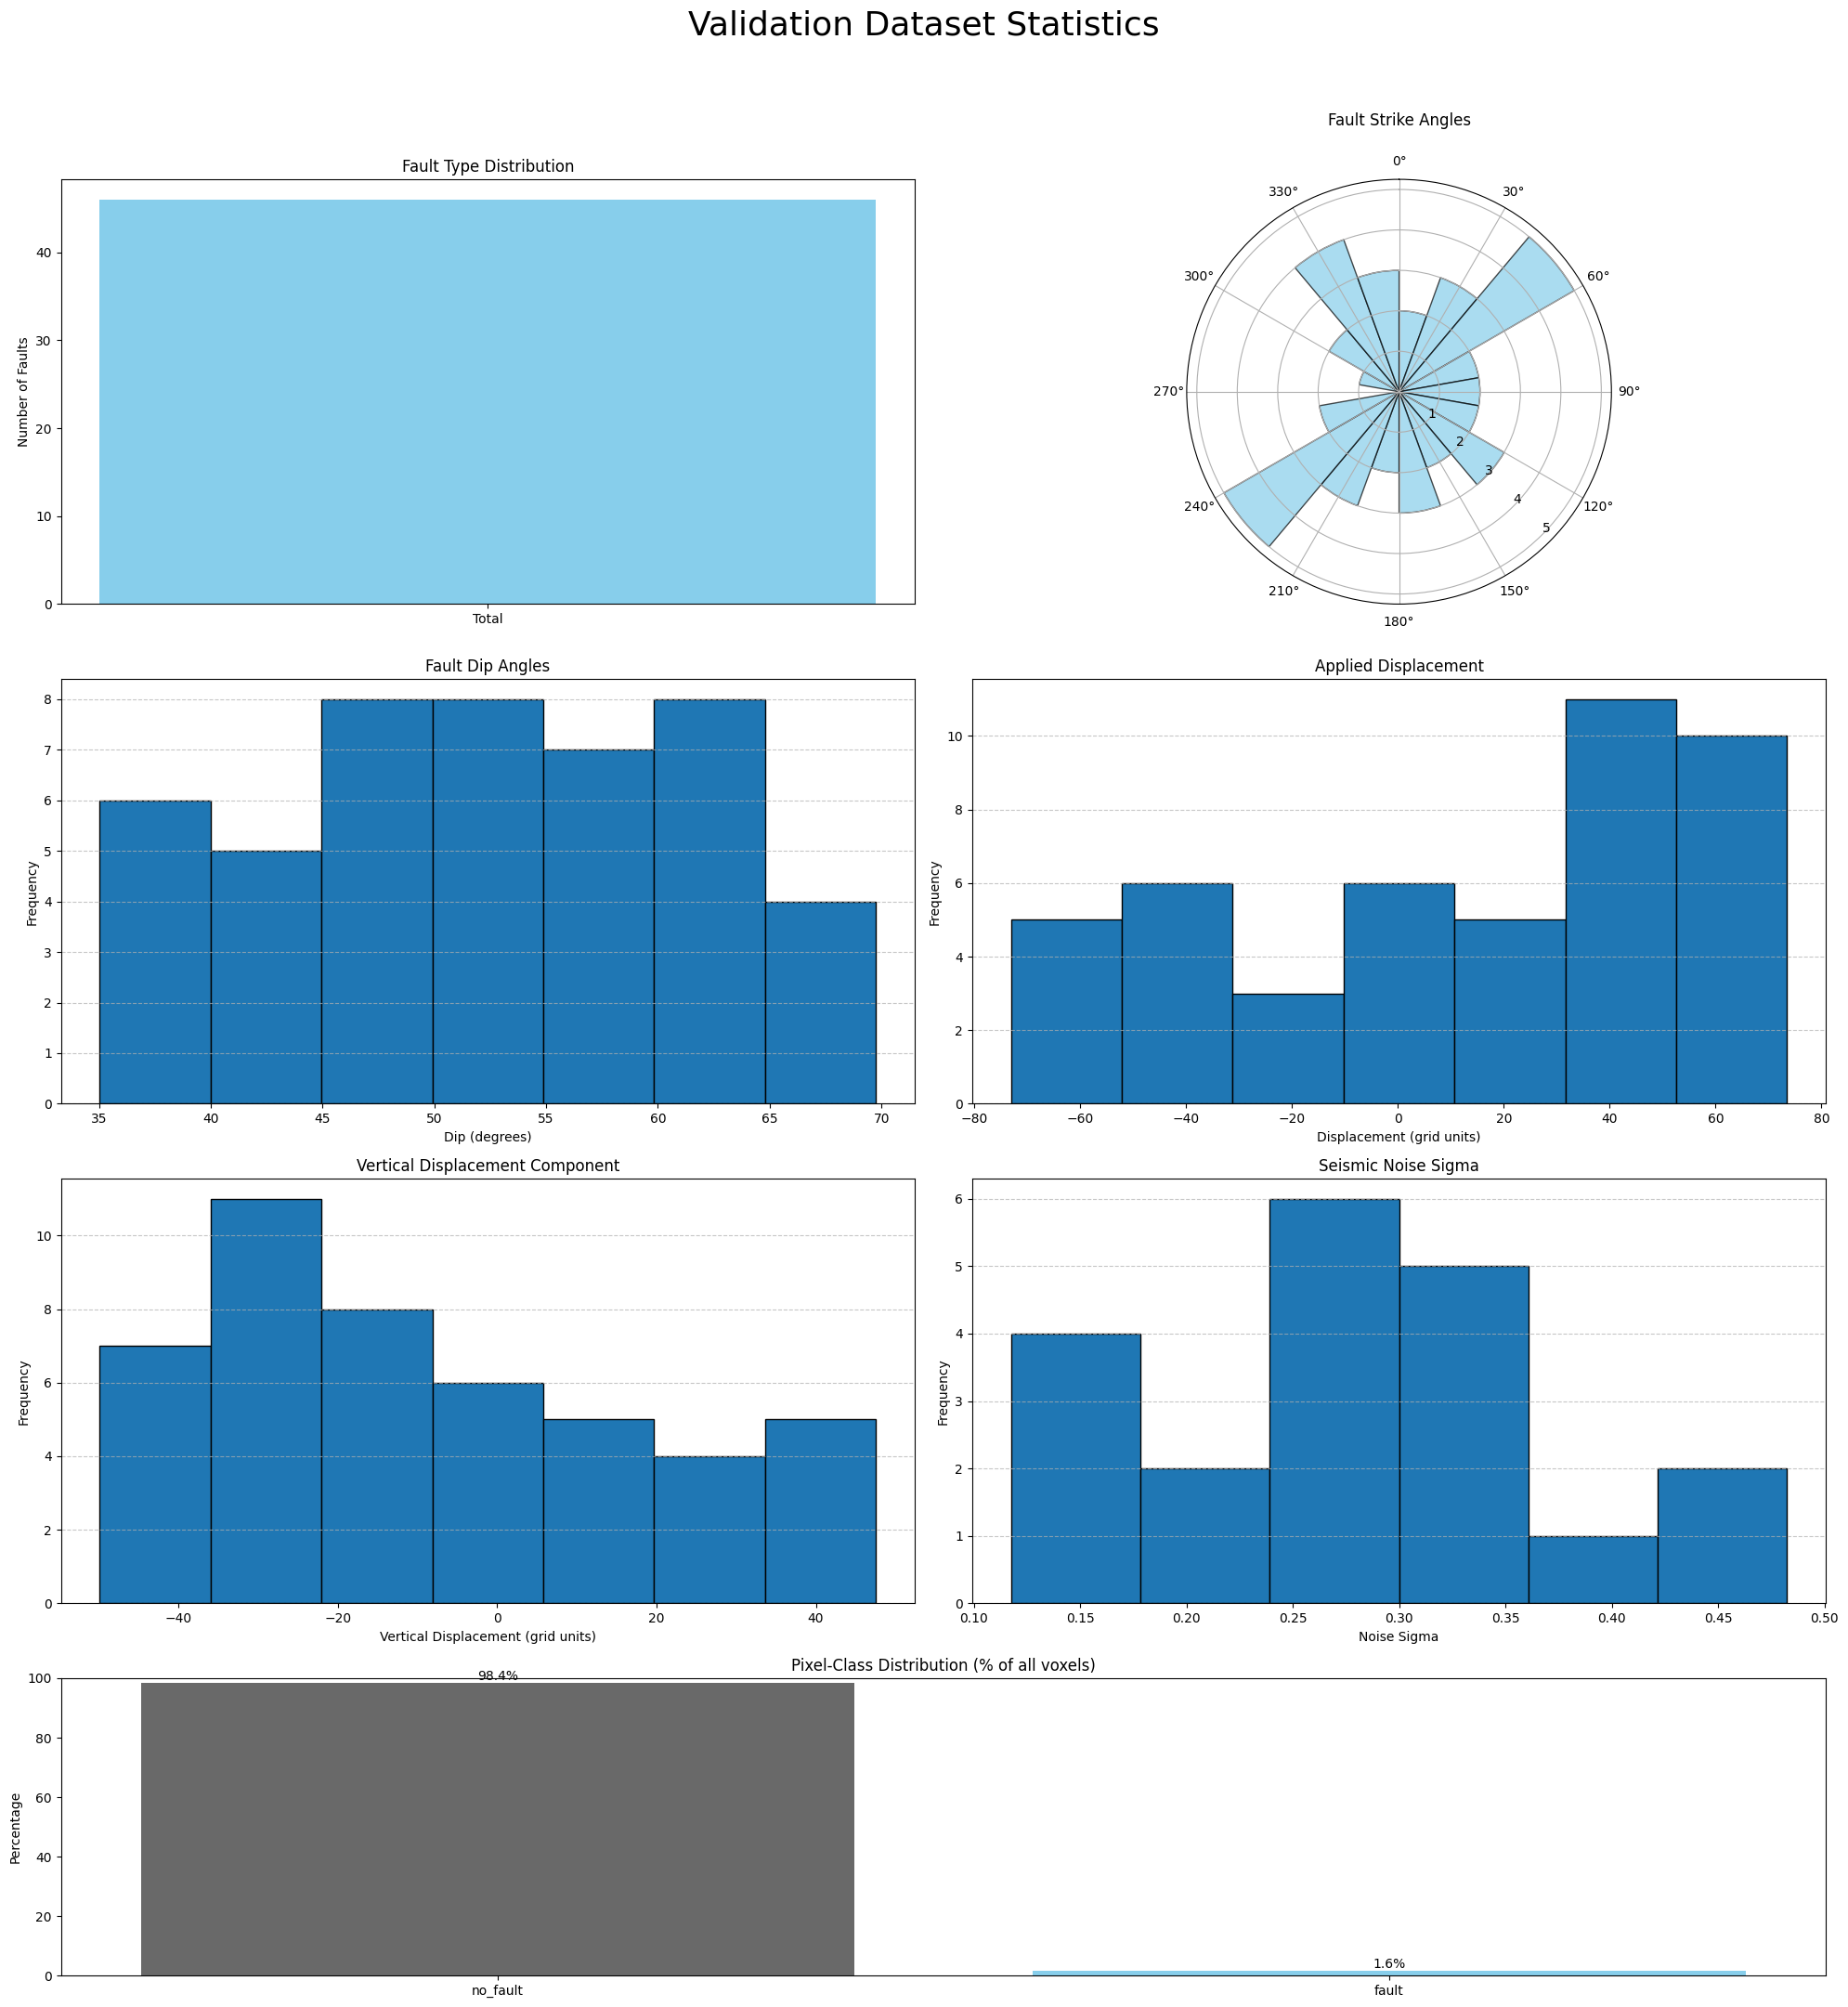

In [12]:

# ─── 3) Display Statistics and Plots for All Splits Individually ──────────────────────────────

# palette for stacked plots
normal_colour  = (0.50, 0.00, 0.50)   # purple  (Normal)
inverse_colour = (0.00, 0.80, 0.00)   # green   (Inverse)
    
for split_name in ['full', 'train', 'validation']:
    stats = all_stats_data.get(split_name)
    print(f"\n--- Displaying Statistics and Plots for {split_name} data ---")

    if not stats or 'cube_level_params' not in stats or 'all_fault_params' not in stats:
        print(f"No statistics available for '{split_name}' split.")
        continue

    # Extract parameters for the current split
    cube_level_params = stats['cube_level_params']
    all_fault_params  = stats['all_fault_params']

    # Create a summary DataFrame
    df = pd.DataFrame(cube_level_params)
    print("\nCube Generation Parameter Summary:")
    print(df.describe())

    # ------------------------------------------------------------------
    # NEW ─ gather all mask cubes for pixel-class statistics
    # ------------------------------------------------------------------
    mask_cubes = []
    splits_to_scan = ['train', 'validation'] if split_name == 'full' else [split_name]
    for split_dir in splits_to_scan:
        mdir = os.path.join(base_out, split_dir, "fault")
        if not os.path.isdir(mdir):
            continue
        for fname in sorted(os.listdir(mdir)):
            if not fname.endswith((".npy", ".dat")):
                continue
            fpath = os.path.join(mdir, fname)
            if fname.endswith(".npy"):
                mask_cubes.append(np.load(fpath))
            else:  # .dat
                mask_cubes.append(np.fromfile(fpath, dtype=np.uint8)
                                  .reshape((cube_size,)*3))

    overall_pct, mean_pct = count_pixels(mask_cubes, mask_mode)

    print("\nPixel-class distribution – OVERALL (% of all voxels):")
    for k, v in overall_pct.items():
        print(f"  {k:>10}: {v:6.2f} %")
    print("Pixel-class distribution – MEAN PER CUBE:")
    for k, v in mean_pct.items():
        print(f"  {k:>10}: {v:6.2f} %")

    # --- Generate and Display Plots ---
    if not all_fault_params:
        print("\nNo fault parameters to plot for this split.")
        continue

    # Extract fault-specific data for plotting
    strikes               = [f['strike'] for f in all_fault_params]
    dips                  = [f['dip'] for f in all_fault_params]
    displacements = [f['applied_disp_signed'] for f in all_fault_params]
    vertical_displacements= [f['vertical_disp_component'] for f in all_fault_params]
    noise_sigmas          = [p.get('noise_sigma')         for p in cube_level_params]

    # Create a figure with a grid of subplots  (NOW 4×2)
    fig = plt.figure(figsize=(20, 22))
    fig.suptitle(f"{split_name.capitalize()} Dataset Statistics", fontsize=26)
    gs = fig.add_gridspec(4, 2, height_ratios=[1, 1, 1, 0.7])

    # Plot Fault Counts
    ax1 = fig.add_subplot(gs[0, 0])

    if mask_mode == 0:
        # binary → one bar
        ax1.bar(['Total'],
                [len(all_fault_params)],
                color=['skyblue'])
    else:
        # multiclass → two bars (Normal, Inverse)
        normal_count  = sum(1 for f in all_fault_params if f['fault_type'] == 'Normal')
        inverse_count = sum(1 for f in all_fault_params if f['fault_type'] == 'Inverse')
        ax1.bar(['Normal', 'Inverse'],
                [normal_count, inverse_count],
                color=[normal_colour, inverse_colour])

    ax1.set_title('Fault Type Distribution')
    ax1.set_ylabel('Number of Faults')

    # Plot Strike Rose Diagram
    ax2 = fig.add_subplot(gs[0, 1], projection='polar')
    if strikes:
        if mask_mode == 1:
            # --- separate angles
            strikes_normal  = np.radians([f['strike'] for f in all_fault_params if f['fault_type'] == 'Normal'])
            strikes_inverse = np.radians([f['strike'] for f in all_fault_params if f['fault_type'] == 'Inverse'])

            num_bins = 18
            bins_rad = np.linspace(0, 2*np.pi, num_bins + 1)
            cnt_norm , _ = np.histogram(strikes_normal , bins=bins_rad)
            cnt_inv  , _ = np.histogram(strikes_inverse, bins=bins_rad)

            centres = bins_rad[:-1] + np.diff(bins_rad)/2
            width   = np.diff(bins_rad)[0]

            # first ring = Normal
            ax2.bar(centres, cnt_norm,
                    width=width,
                    bottom=0.0,
                    color=normal_colour,
                    edgecolor='black',
                    alpha=0.8,
                    label='Normal')
            # stacked on top = Inverse
            ax2.bar(centres, cnt_inv,
                    width=width,
                    bottom=cnt_norm,
                    color=inverse_colour,
                    edgecolor='black',
                    alpha=0.8,
                    label='Inverse')

            ax2.legend(loc='lower left', bbox_to_anchor=(1.05, 0.0))
            ax2.set_title('Fault Strike Angles', va='bottom', y=1.1)
        else:
            plot_rose_diagram(strikes, ax=ax2, title='Fault Strike Angles')

    # Plot Dip Histogram
    ax3 = fig.add_subplot(gs[1, 0])

    if dips:
        if mask_mode == 1:
            dips_normal  = [f['dip'] for f in all_fault_params if f['fault_type'] == 'Normal']
            dips_inverse = [f['dip'] for f in all_fault_params if f['fault_type'] == 'Inverse']
            ax3.hist([dips_normal, dips_inverse],
                     bins='auto',
                     stacked=True,
                     color=[normal_colour, inverse_colour],
                     label=['Normal', 'Inverse'],
                     edgecolor='black')
            ax3.legend()
        else:
            plot_histogram(dips, ax=ax3, title='Fault Dip Angles',
                           xlabel='Dip (degrees)')
        ax3.set_title('Fault Dip Angles')
        ax3.set_xlabel('Dip (degrees)')

    # Plot Displacement Histogram
    ax4 = fig.add_subplot(gs[1, 1])
    if displacements:
        if mask_mode == 1:
            disp_normal  = [f['applied_disp_signed'] for f in all_fault_params if f['fault_type'] == 'Normal']
            disp_inverse = [f['applied_disp_signed'] for f in all_fault_params if f['fault_type'] == 'Inverse']
            ax4.hist([disp_normal, disp_inverse],
                     bins='auto',
                     stacked=True,
                     color=[normal_colour, inverse_colour],
                     label=['Normal', 'Inverse'],
                     edgecolor='black')
            ax4.legend()
        else:
            plot_histogram(displacements, ax=ax4, title='Applied Displacement',
                           xlabel='Displacement (grid units)')
        ax4.set_title('Applied Displacement')
        ax4.set_xlabel('Displacement (grid units)')

    # Plot Vertical Displacement Histogram
    ax5 = fig.add_subplot(gs[2, 0])
    if vertical_displacements:
        if mask_mode == 1:
            vdisp_normal  = [f['vertical_disp_component'] for f in all_fault_params if f['fault_type'] == 'Normal']
            vdisp_inverse = [f['vertical_disp_component'] for f in all_fault_params if f['fault_type'] == 'Inverse']
            ax5.hist([vdisp_normal, vdisp_inverse],
                     bins='auto',
                     stacked=True,
                     color=[normal_colour, inverse_colour],
                     label=['Normal', 'Inverse'],
                     edgecolor='black')
            ax5.legend()
        else:
            plot_histogram(vertical_displacements, ax=ax5,
                           title='Vertical Displacement Component',
                           xlabel='Vertical Displacement (grid units)')
        ax5.set_title('Vertical Displacement Component')
        ax5.set_xlabel('Vertical Displacement (grid units)')

    # Plot Noise Sigma Histogram
    ax6 = fig.add_subplot(gs[2, 1])
    if any(n is not None for n in noise_sigmas):
        plot_histogram([n for n in noise_sigmas if n is not None],
                       ax=ax6, title='Seismic Noise Sigma',
                       xlabel='Noise Sigma')

    # ------------------------------------------------------------------
    # NEW subplot: pixel-class distribution
    # ------------------------------------------------------------------
    ax7 = fig.add_subplot(gs[3, :])
    categories = list(overall_pct.keys())

    if mask_mode == 0:
        colours = ['dimgrey', 'skyblue'][:len(categories)]
    else:
        colour_map = {
            'no_fault': 'dimgrey',
            'normal'  : (0.50, 0.00, 0.50),  # purple
            'inverse' : (0.00, 0.80, 0.00)   # green
        }
        colours = [colour_map[c] for c in categories]

    ax7.bar(categories,
            [overall_pct[k] for k in categories],
            color=colours)
    ax7.set_ylim(0, 100)
    ax7.set_title('Pixel-Class Distribution (% of all voxels)')
    ax7.set_ylabel('Percentage')
    for i, k in enumerate(categories):
        ax7.text(i, overall_pct[k] + 1, f"{overall_pct[k]:.1f}%", ha='center')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    img_path = os.path.join(IMAGE_DIR, f"{split_name}_dataset_stats.png")
    fig.savefig(img_path, dpi=300)
    print(f"Saved figure → {img_path}")
    plt.show()


---

In [13]:
# Prepare colormaps for sample slices
bw_cmap             = "gray"
overlay_bw_cmap     = ListedColormap([(0,0,0,0), (1,1,1,1)]) # Transparent to White

mask_color_alone_cmap   = ListedColormap([
    (0.00, 0.00, 0.00, 1.0),  # 0 → black
    (0.50, 0.00, 0.50, 1.0),  # 1 → purple (Normal)
    (0.00, 0.80, 0.00, 1.0)   # 2 → green (Inverse)
])
mask_color_overlay_cmap = ListedColormap([
    (0,0,0,0),           # 0 → transparent
    (0.50,0.00,0.50,1),  # 1 → purple (Normal)
    (0.00,0.80,0.00,1)   # 2 → green (Inverse)
])

# Select colormap depending on mask_mode
if mask_mode == 0:
    mask_alone_cmap_slice   = bw_cmap
    mask_overlay_cmap_slice = overlay_bw_cmap
else:
    mask_alone_cmap_slice   = mask_color_alone_cmap
    mask_overlay_cmap_slice = mask_color_overlay_cmap

# Transparency factor for overlays
overlay_alpha = 1.0

---

---

### 3D Visualization

In [14]:
# Function to normalize to 0-255 uint8
def normalize(v):
    return ((v - v.min()) / (v.max() - v.min()) * 255).astype(np.uint8)

# Function to plot fault points
def plot_fault_points(fig, slice_mask, axis_index, slice_type, color, label, nx, ny, nz):
    if slice_type == "inline":
        ks, js = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=np.full_like(ks, axis_index),
            y=js,
            z=nz - 1 - ks,
            mode='markers',
            marker=dict(color=color, size=2),
            name=label
        ))
    elif slice_type == "crossline":
        ks, is_ = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=is_,
            y=np.full_like(is_, axis_index),
            z=nz - 1 - ks,
            mode='markers',
            marker=dict(color=color, size=2),
            name=label
        ))
    elif slice_type == "timeslice":
        is_, js = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=is_,
            y=js,
            z=np.full_like(is_, axis_index),
            mode='markers',
            marker=dict(color=color, size=2),
            name=label
        ))

In [15]:
# Normalization helper
def normalize(v):
    return ((v - v.min()) / (v.max() - v.min()) * 255).astype(np.uint8)

In [16]:
# Fault plotting function
def plot_fault_points(fig, slice_mask, axis_index, slice_type, color, label, nx, ny, nz):
    if slice_type == "inline":
        ks, js = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=np.full_like(ks, axis_index),
            y=js,
            z=nz - 1 - ks,
            mode='markers',
            marker=dict(color=color, size=2, opacity=1),
            name=label
        ))
    elif slice_type == "crossline":
        ks, is_ = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=is_,
            y=np.full_like(is_, axis_index),
            z=nz - 1 - ks,
            mode='markers',
            marker=dict(color=color, size=2, opacity=1),
            name=label
        ))
    elif slice_type == "timeslice":
        is_, js = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=is_,
            y=js,
            z=np.full_like(is_, axis_index),
            mode='markers',
            marker=dict(color=color, size=2, opacity=1),
            name=label
        ))

In [17]:
# --------------------------------------------------------------------------
# 3-D preview of one cube + fault-by-fault table
# --------------------------------------------------------------------------

def show_fault_cube(split:str, idx:int|None=None, *, seed:int|None=None):
    """
    Visualise a random (or chosen) cube and list every individual fault.

    Parameters
    ----------
    split : {"train", "validation"}
    idx   : int | None
        Exact cube-index (global index used for the file-name).  If *None*
        a cube is selected at random **but only among cubes that contain ≥ 1
        faults**.
    seed  : int | None
        Fixes RNG state so the *same* random cube is chosen every run.
    """

    if seed is not None:
        random.seed(seed)

    # ------------------------------------------------------------------ paths
    seis_dir  = os.path.join(base_out, split, "seis")
    mask_dir  = os.path.join(base_out, split, "fault")
    stats_f   = os.path.join(STATS_DIR, f"statistics_{split}.json")

    if not (os.path.isdir(seis_dir) and os.path.isdir(mask_dir)):
        print(f"[{split}]   output folders not found.")
        return
    if not os.path.exists(stats_f):
        print(f"[{split}]   statistics file missing: {stats_f}")
        return

    # ---------------------------------------------------------------- stats –
    with open(stats_f, "r") as f:
        stats_json = json.load(f)
    # map cube-id → list[dict]  (one dict per fault)
    by_cube = {}
    for fp in stats_json["all_fault_params"]:
        by_cube.setdefault(fp["cube_id"], []).append(fp)

    # all cubes that *actually* have faults
    cubes_with_faults = [cid for cid, lst in by_cube.items() if len(lst) > 0]

    # ---------------------------------------------------------------- pick id
    if idx is None:
        if not cubes_with_faults:
            print(f"[{split}]   no faults at all in this split.")
            return
        idx = random.choice(cubes_with_faults)
    else:
        # sanity-check requested id
        if idx not in by_cube or len(by_cube[idx]) == 0:
            print(f"[{split}]   cube {idx} exists but has no faults.")
            return

    fname = f"{idx}.{output_format}"
    if not (os.path.exists(os.path.join(seis_dir, fname)) and
            os.path.exists(os.path.join(mask_dir, fname))):
        print(f"[{split}]   data files for cube {idx} not found.")
        return

    print(f"[{split}] cube {idx}  →  {fname}")

    # ---------------------------------------------------------------- load vol
    if fname.endswith(".npy"):
        seismic = np.load(os.path.join(seis_dir,  fname))
        mask    = np.load(os.path.join(mask_dir,  fname))
    else:  # ".dat"
        shape  = (cube_size,)*3
        seismic = np.fromfile(os.path.join(seis_dir,  fname),
                              dtype=np.float32).reshape(shape)
        mask    = np.fromfile(os.path.join(mask_dir,  fname),
                              dtype=np.uint8 ).reshape(shape)

    nx, ny, nz = seismic.shape
    inline,  inline_m   = seismic[nx//2,:,:].T, mask[nx//2,:,:].T
    crossline, cross_m  = seismic[:,ny//2,:].T, mask[:,ny//2,:].T
    timeslice, times_m  = seismic[:,:,nz//2]  , mask[:,:,nz//2]

    # normalise slices for Surface display
    norm = lambda v: ((v-v.min())/(v.max()-v.min()+1e-12)*255).astype(np.uint8)
    inline_n, cross_n, time_n = map(norm, (inline, crossline, timeslice))

    # ---------------------------------------------------------------- figure
    fig = make_subplots(rows=1, cols=2,
                        specs=[[{'type':'scene'}, {'type':'table'}]],
                        column_widths=[0.75, 0.25],
                        horizontal_spacing=0.04)

    # seismic surfaces
    fig.add_trace(go.Surface(z=np.tile(np.arange(nz)[::-1], (ny,1)).T,
                             x=np.full((nz,ny), nx//2),
                             y=np.tile(np.arange(ny), (nz,1)),
                             surfacecolor=inline_n, colorscale="Gray",
                             showscale=False),
                  row=1,col=1)
    fig.add_trace(go.Surface(z=np.tile(np.arange(nz)[::-1], (nx,1)).T,
                             x=np.tile(np.arange(nx), (nz,1)),
                             y=np.full((nz,nx), ny//2),
                             surfacecolor=cross_n, colorscale="Gray",
                             showscale=False),
                  row=1,col=1)
    fig.add_trace(go.Surface(z=np.full((ny,nx), nz//2),
                             x=np.tile(np.arange(nx), (ny,1)),
                             y=np.tile(np.arange(ny).reshape(-1,1), (1,nx)),
                             surfacecolor=np.rot90(time_n, k=-1),
                             colorscale="Gray", showscale=False),
                  row=1,col=1)

    # fault dots
    if mask_mode == 0:               # binary
        from utilities import plot_fault_points
        plot_fault_points(fig, inline_m==1 , nx//2, "inline"   ,"white","Inline", nx,ny,nz)
        plot_fault_points(fig, cross_m==1  , ny//2, "crossline","white","Cross",  nx,ny,nz)
        plot_fault_points(fig, times_m==1  , nz//2, "timeslice","white","T-slice",nx,ny,nz)
    else:                            # multi-class
        colours = {1:"green", 2:"purple"}
        for cls,label in [(1,"Normal"), (2,"Inverse")]:
            plot_fault_points(fig, inline_m==cls , nx//2,"inline",   colours[cls],f"Inl {label}", nx,ny,nz)
            plot_fault_points(fig, cross_m==cls  , ny//2,"crossline",colours[cls],f"Xl  {label}", nx,ny,nz)
            plot_fault_points(fig, times_m==cls  , nz//2,"timeslice",colours[cls],f"Tsl {label}", nx,ny,nz)

    # ---------------------------------------------------------------- table
    faults = by_cube[idx]                      # list[dict], already non-empty
    dips     = [f["dip"]                 for f in faults]
    strikes  = [f["strike"]              for f in faults]
    slips    = [f["applied_disp_signed"] for f in faults]
    if mask_mode == 1:
        ftypes = [f["fault_type"] or "?" for f in faults]

    col_vals = [["#",
                 "Dip (°)",
                 "Strike (°)",
                 "Slip (vox)"] +
                (["Type"] if mask_mode == 1 else []),
                list(range(1, len(faults)+1)),
                [f"{d:5.1f}" for d in dips],
                [f"{s:6.1f}" for s in strikes],
                [f"{sl:6.1f}"for sl in slips]]
    if mask_mode == 1:
        col_vals.append(ftypes)

    header = dict(values=col_vals[0], align="center", fill_color="#d3d3d3")
    cells  = dict(values=col_vals[1:], align="center")
    fig.add_trace(go.Table(header=header, cells=cells), row=1, col=2)

    # ---------------------------------------------------------------- layout
    fig.update_layout(title=f"{split.upper()} cube {idx}",
                      scene=dict(aspectmode="data",
                                 xaxis_visible=False,
                                 yaxis_visible=False,
                                 zaxis_visible=False),
                      margin=dict(l=0, r=0, t=40, b=0))
    display(fig)


In [25]:
show_fault_cube("train")          # random training cube or show_fault_cube("train", idx=42) # specific cube if you know the index

[train] cube 64  →  64.npy


In [23]:
show_fault_cube("validation") # random validation cube

[validation] cube 95  →  95.npy
